In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import read_nml as rnl

from Utils import numerical_utils as nuti
from Utils import constants as Co

print( Co.cpair())

cpair = Co.cpair()
grav= Co.grav()

1004.6480897776704


In [2]:
# Replace with your path
case='Baseline_QxQ_x01'
odir = f"../cases/{case}"

nml_path = f"{odir}/atm_in"

nml = rnl.read_namelist(nml_path)
group_name, active = rnl.choose_active_group(nml)

print(f"Active group: {group_name}")
# Access fields robustly
bnd_topo = active.get('bnd_topo')
ncdata = active.get('ncdata')
scale = active.get('scale_dry_air_mass')
use_topo = active.get('use_topo_file')

print("bnd_topo:", bnd_topo)
print("ncdata:", ncdata)
print("scale_dry_air_mass:", scale)
print("use_topo_file:", use_topo)


Active group: cam_initfiles_nl_xy
bnd_topo: /glade/work/juliob/bndtopo/fv1x1_gmted2010_modis_bedmachine_nc3000_Laplace0100_noleak_greenlndantarcsgh30fac2.50_20251009.nc
ncdata: /glade/derecho/scratch/juliob/archive//c153_topfix_ne240pg3_FMTHIST_xic_x02/atm/fv1x1/c153_topfix_ne240pg3_FMTHIST_xic_x02.cam.h1i.2004-07-02-00000.nc
scale_dry_air_mass: 98288.0
use_topo_file: True


In [3]:
print( active )

{'bnd_topo': '/glade/work/juliob/bndtopo/fv1x1_gmted2010_modis_bedmachine_nc3000_Laplace0100_noleak_greenlndantarcsgh30fac2.50_20251009.nc', 'ncdata': '/glade/derecho/scratch/juliob/archive//c153_topfix_ne240pg3_FMTHIST_xic_x02/atm/fv1x1/c153_topfix_ne240pg3_FMTHIST_xic_x02.cam.h1i.2004-07-02-00000.nc', 'scale_dry_air_mass': 98288.0, 'use_topo_file': True, 'ncdata_type': 'XY_DATA'}


In [4]:

# Open the binary file
with open(f"{odir}/GW.dat", 'rb') as f:
    # Read the dimensions (ncol, nlev) - Fortran writes integers in 4 bytes by default
    ncol, nlev = np.fromfile(f, dtype=np.int32, count=2)
    print(f"Dimensions read from file: ncol={ncol}, nlev={nlev}")
    lat = np.fromfile(f, dtype=np.float64, count=ncol  )                                               #.reshape((ncol, nlev+1), order='F')
    lon = np.fromfile(f, dtype=np.float64, count=ncol  )                                               #.reshape((ncol, nlev+1), order='F')
    sgh = np.fromfile(f, dtype=np.float64, count=ncol  )                                               #.reshape((ncol, nlev+1), order='F')



    
    # Read arrays (Here 3D phys ==> two dimensional array). Dims in Fortran order
    zm = np.fromfile(f, dtype=np.float64, count=ncol * nlev).reshape((ncol, nlev), order='F')
    zi = np.fromfile(f, dtype=np.float64, count=ncol * (nlev+1) ).reshape((ncol, nlev+1), order='F')

    pmid = np.fromfile(f, dtype=np.float64, count=ncol * nlev).reshape((ncol, nlev), order='F')
    pint = np.fromfile(f, dtype=np.float64, count=ncol * (nlev+1) ).reshape((ncol, nlev+1), order='F')
    
    uu = np.fromfile(f, dtype=np.float64, count=ncol * nlev).reshape((ncol, nlev), order='F')
    vv = np.fromfile(f, dtype=np.float64, count=ncol * nlev).reshape((ncol, nlev), order='F')

    # read booleans (4 bytes each)
    flags_int = np.fromfile(f, dtype=np.int32, count=2)
    use_gw_rdg_beta , use_gw_movmtn_pbl = flags_int != 0  # convert to booleans

    print( f"Boolean use_gw_rdg_beta and use_gw_movmtn_pbl vars => {use_gw_rdg_beta} {use_gw_movmtn_pbl}" )
    
    tau_a = np.fromfile(f, dtype=np.float64, count=ncol * (nlev+1) ).reshape((ncol, nlev+1), order='F')
    tau_b = np.fromfile(f, dtype=np.float64, count=ncol * (nlev+1) ).reshape((ncol, nlev+1), order='F')

    bwv = np.fromfile(f, dtype=np.float64, count=ncol  )                                               #.reshape((ncol, nlev+1), order='F')
    tlb = np.fromfile(f, dtype=np.float64, count=ncol  )                                               #.reshape((ncol, nlev+1), order='F')
    wbr = np.fromfile(f, dtype=np.float64, count=ncol  )                                               #.reshape((ncol, nlev+1), order='F')

    ubmsrc = np.fromfile(f, dtype=np.float64, count=ncol  )                                               #.reshape((ncol, nlev+1), order='F')
    nsrc = np.fromfile(f, dtype=np.float64, count=ncol  )                                               #.reshape((ncol, nlev+1), order='F')

    tauoro = np.fromfile(f, dtype=np.float64, count=ncol  )                                               #.reshape((ncol, nlev+1), order='F')
    taudsw = np.fromfile(f, dtype=np.float64, count=ncol  )                                               #.reshape((ncol, nlev+1), order='F')
    
    ubm = np.fromfile(f, dtype=np.float64, count=ncol * (nlev) ).reshape((ncol, nlev), order='F')
    tau = np.fromfile(f, dtype=np.float64, count=ncol * (nlev+1) ).reshape((ncol, nlev+1), order='F')
    tau_diag = np.fromfile(f, dtype=np.float64, count=ncol * (nlev+1) ).reshape((ncol, nlev+1), order='F')

    if (use_gw_movmtn_pbl==True):
        ubm_movmtn  = np.fromfile(f, dtype=np.float64, count=ncol * (nlev) ).reshape((ncol, nlev), order='F')
        vort_movmtn = np.fromfile(f, dtype=np.float64, count=ncol * (nlev) ).reshape((ncol, nlev), order='F')
        tau_movmtn  = np.fromfile(f, dtype=np.float64, count=ncol * (nlev+1) ).reshape((ncol, nlev+1), order='F')

# 


Dimensions read from file: ncol=55296, nlev=93
Boolean use_gw_rdg_beta and use_gw_movmtn_pbl vars => True True


In [5]:
print( tau.shape )

(55296, 94)


In [6]:

print( ncdata )
print(active['ncdata_type'])


/glade/derecho/scratch/juliob/archive//c153_topfix_ne240pg3_FMTHIST_xic_x02/atm/fv1x1/c153_topfix_ne240pg3_FMTHIST_xic_x02.cam.h1i.2004-07-02-00000.nc
XY_DATA


In [7]:
#
X=xr.open_dataset( ncdata )

In [8]:
X

<xarray.Dataset> Size: 247MB
Dimensions:      (time: 1, nbnd: 2, ilev: 94, lev: 93, lat: 192, lon: 288)
Coordinates:
  * lon          (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat          (lat) float64 2kB -89.76 -89.06 -88.12 ... 88.12 89.06 89.76
  * lev          (lev) float64 744B 0.008135 0.01834 0.03482 ... 991.2 997.5
  * ilev         (ilev) float64 752B 0.004259 0.01201 0.02467 ... 995.1 1e+03
  * nbnd         (nbnd) int64 16B 0 1
  * time         (time) object 8B 2004-07-02 00:00:00
Data variables:
    time_bounds  (time, nbnd) object 16B ...
    hyai         (ilev) float64 752B ...
    hybi         (ilev) float64 752B ...
    hyam         (lev) float64 744B ...
    hybm         (lev) float64 744B ...
    upwp         (time, lev, lat, lon) float64 41MB ...
    vpwp         (time, lev, lat, lon) float64 41MB ...
    PS           (time, lat, lon) float64 442kB ...
    U            (time, lev, lat, lon) float64 41MB ...
    V            (time, lev, lat, lon) float64 41MB ...
    OMEGA        (time, lev, lat, lon) float64 41MB ...
    T            (time, lev, lat, lon) float64 41MB ...

In [42]:
if (active['ncdata_type'] == 'XY_DATA' ):
    dims=np.array( X.dims.values )
    nt = X.sizes['time'] 
    nz = X.sizes['lev'] 
    ny = X.sizes['lat'] 
    nx = X.sizes['lon'] 
    print( X.upwp.values.shape )
    lat_yx = lat.reshape( [nx,ny] )
    sgh_yx = sgh.reshape( [ny,nx] )
    # This reshaping seems to work
    # It is bizarre but we will just go with it.
    zm_yxz = zm.reshape( [ny,nx,nz] )
    pmid_yxz = pmid.reshape( [ny,nx,nz] )
    uu_yxz = uu.reshape( [ny,nx,nz] )
    vv_yxz = vv.reshape( [ny,nx,nz] )
    zeta_yxz = vort_movmtn.reshape( [ny,nx,nz] )
    tau_movmtn_yxz = tau_movmtn.reshape( [ny,nx,nz+1] )
    tau_rdg_yxz = tau.reshape( [ny,nx,nz+1] )
    

(1, 93, 192, 288)


In [10]:
if (active['ncdata_type'] == 'XY_DATA' ):
    # NOte, here the '_m' tag refers to CAM's
    # t,z,y,x dimensions (z optional )
    lon1 = X.lon.values
    lat1 = X.lat.values
    plev = X.lev.values
    upwp_m=X.upwp.values
    vpwp_m=X.vpwp.values
    uu_m=X.U.values
    vv_m=X.V.values
    te_m=X.T.values
    og_m=X.OMEGA.values
    
    mpwp_m=np.sqrt( upwp_m**2 + vpwp_m**2 )
    Topo=xr.open_dataset(bnd_topo)
    htopo_yx=Topo.PHIS.values/9.8
    zeta_m = np.zeros(  (nt,nz,ny,nx) )
    for z in np.arange( nz ):
        zeta_m[0,z,:,:] = nuti.Sphere_Curl2( f_x=uu_m[0,z,:,:], f_y=vv_m[0,z,:,:], lat=lat1, lon=lon1, wrap=True )
        #print( z )

print( htopo_yx.shape )


(192, 288)


In [11]:
movmtn_plaunch = 32500.0
movmtn_psteer = 65000.0
print(plev*100.)
ksteer=np.argmin( np.abs(plev*100.-movmtn_psteer) )
klaunch=np.argmin( np.abs(plev*100.-movmtn_plaunch) )
print(ksteer,klaunch)

[8.13463418e-01 1.83426338e+00 3.48175540e+00 5.95437008e+00
 9.81709651e+00 1.61856556e+01 2.66856354e+01 4.39971750e+01
 7.25390768e+01 1.19596754e+02 1.89095558e+02 2.80419527e+02
 3.91861528e+02 5.19038707e+02 6.56445674e+02 7.98981582e+02
 9.42951710e+02 1.08636439e+03 1.22871883e+03 1.37057684e+03
 1.51313709e+03 1.65790800e+03 1.80649882e+03 1.96050399e+03
 2.12145119e+03 2.29079254e+03 2.46991052e+03 2.66013631e+03
 2.86173967e+03 3.07506633e+03 3.30274864e+03 3.54728887e+03
 3.80993521e+03 4.09202827e+03 4.39500790e+03 4.72042057e+03
 5.06992726e+03 5.44531193e+03 5.84849062e+03 6.28152123e+03
 6.74661405e+03 7.24614300e+03 7.78265780e+03 8.35889692e+03
 8.97780160e+03 9.64253088e+03 1.03564777e+04 1.11232861e+04
 1.19468701e+04 1.28314335e+04 1.37814911e+04 1.48018925e+04
 1.58978458e+04 1.70749450e+04 1.83391984e+04 1.96970589e+04
 2.11554573e+04 2.27218376e+04 2.44041950e+04 2.62111165e+04
 2.81518250e+04 3.02362264e+04 3.24749599e+04 3.48794524e+04
 3.74619770e+04 4.023571

In [12]:
print( np.shape(zm_yxz))
print( np.shape(te_m))

dse_yxz= np.zeros( (ny,nx,nz) )
zma_yxz= np.zeros( (ny,nx,nz) )
for k in np.arange( nz ):
    zma_yxz[:,:,k] = zm_yxz[:,:,k] + htopo_yx[:,:]
    dse_yxz[:,:,k] = grav*(zm_yxz[:,:,k] + htopo_yx[:,:]) + cpair*te_m[0,k,:,:]



(192, 288, 93)
(1, 93, 192, 288)


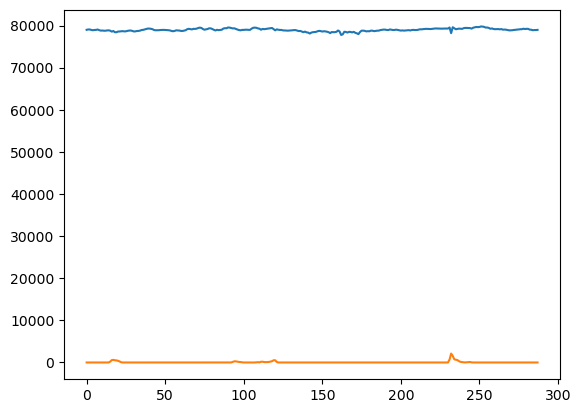

In [13]:
#plt.contour( zma_yxz[:,:,80], levels=51 )
plt.plot( zma_yxz[60,:,0] )
plt.plot( htopo_yx[60,:] )

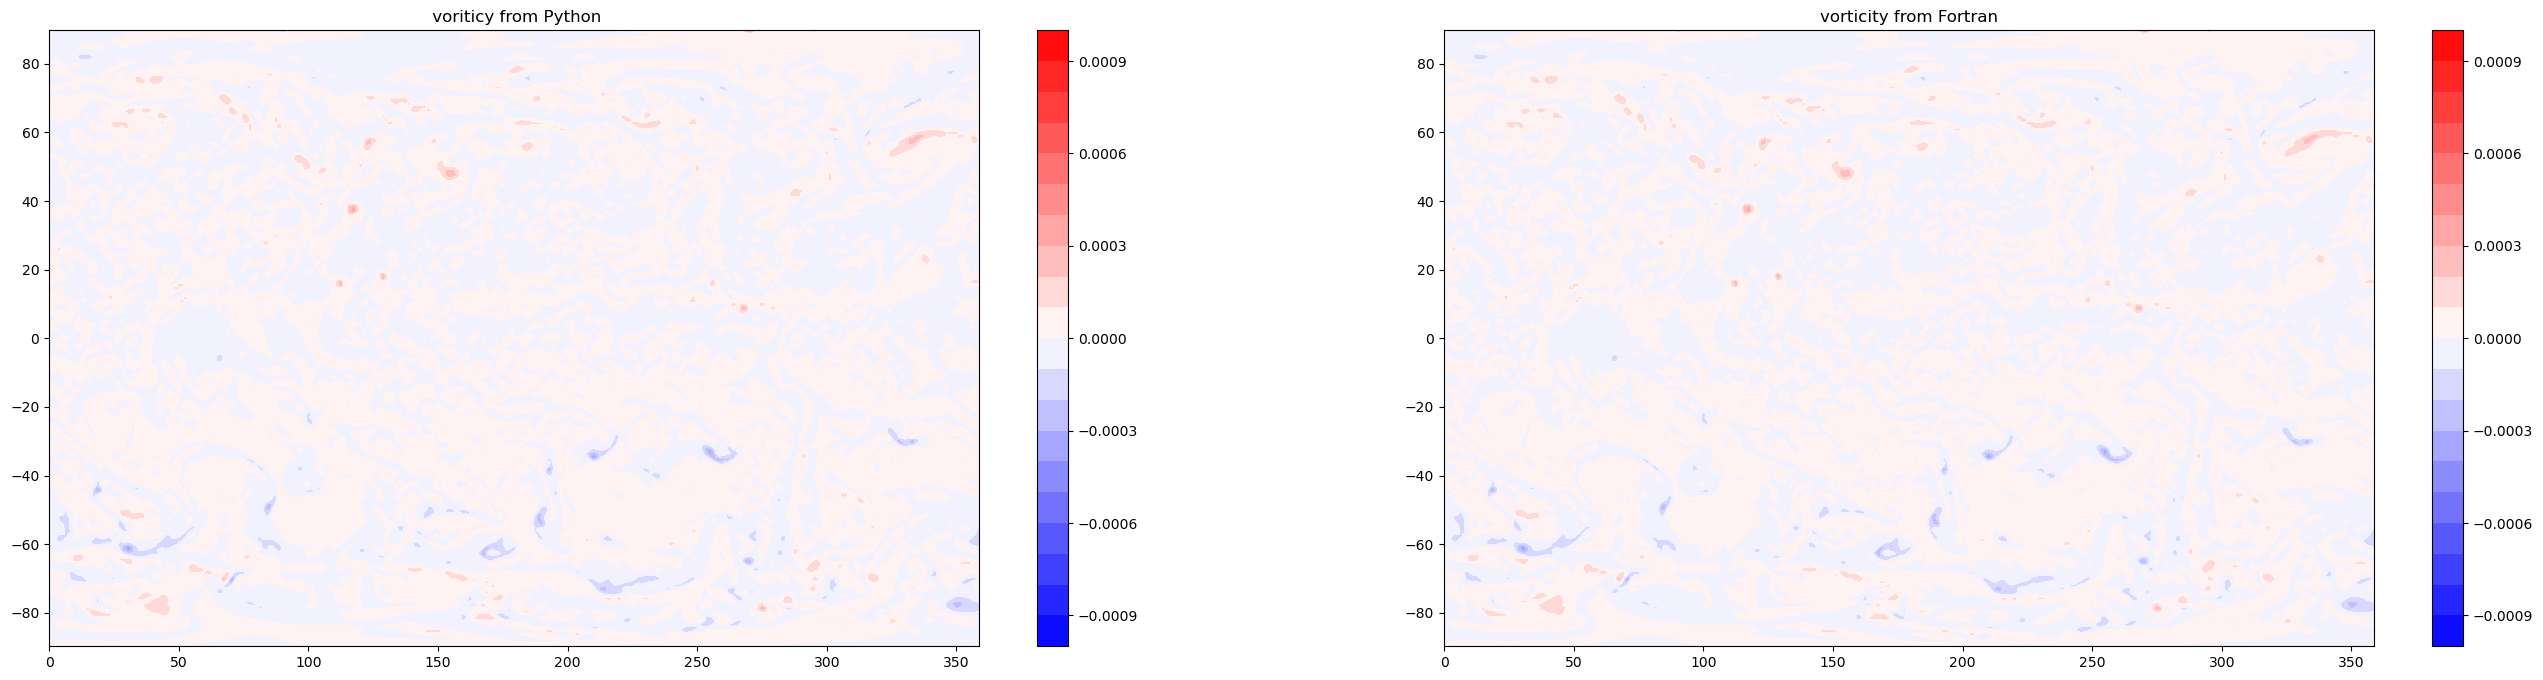

In [14]:
fig,axs=plt.subplots( 1,2, figsize=(33,8) )

t,z=0,80
levels=1e-3 * np.linspace( -1,1,num=21)
cmap='bwr'

ax=axs[0]
c=ax.contourf( lon1, lat1, zeta_m[t,z,:,:] , levels= levels, cmap=cmap ) # vort_movmtn[:,90] )
ax.set_title( ' voriticy from Python' )
plt.colorbar(c)
ax=axs[1]
c=ax.contourf( lon1, lat1, zeta_yxz[:,:,z] , levels= levels, cmap=cmap  ) # vort_movmtn[:,90] )
ax.set_title( 'vorticity from Fortran' )
plt.colorbar(c)


In [24]:
plev=X.lev.values
zlev= -7 *np.log( plev/1_000.)

18.872906006759255
[402.35715327 432.14825256 464.14512746 498.51109676 535.42157159
 574.2534451  612.85953891]
-52.30366492146594


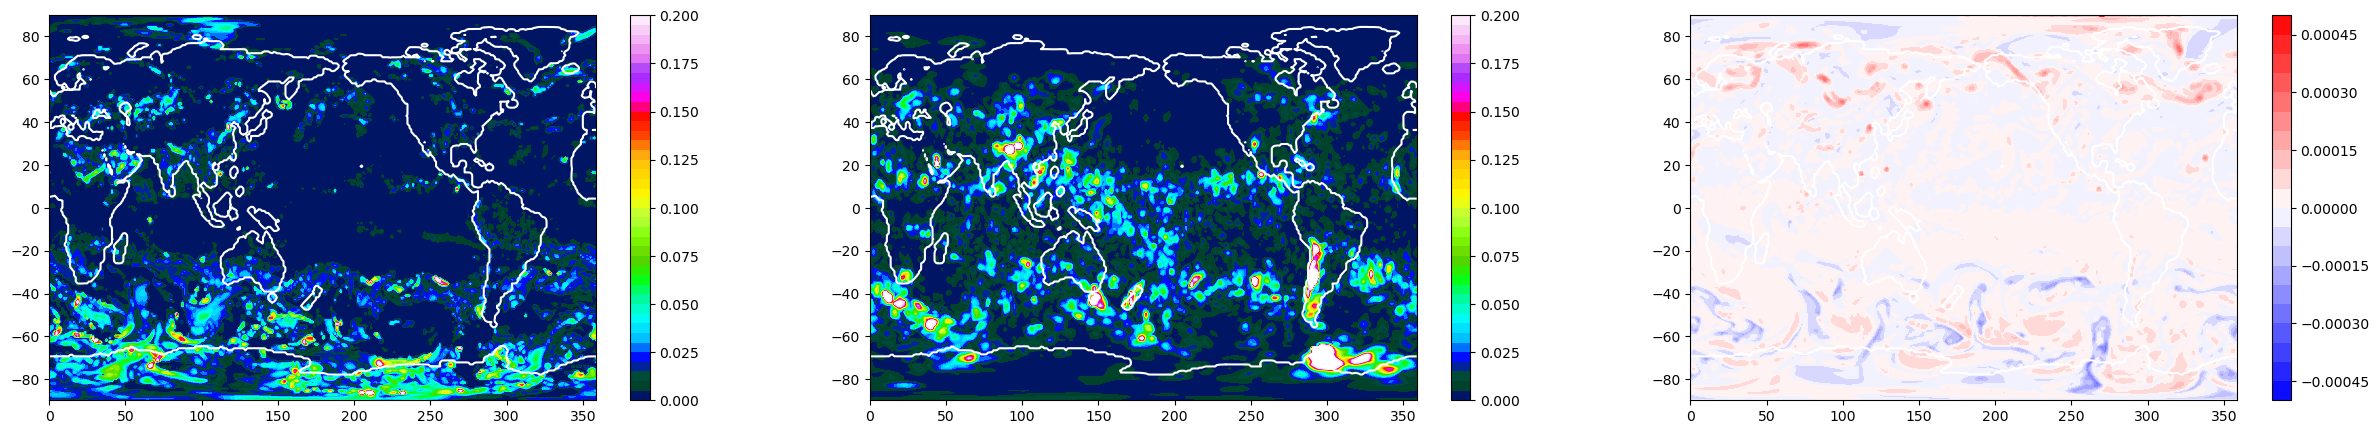

In [40]:
tau_plot=tau_movmtn # +tau

mflev=0.1*np.linspace(0,5,num=26)
ztlev=1e-3 * np.linspace( -1,1,num=21)
mflev=2*np.linspace(0,0.1,num=41)

z=11
z=40
zsrc=60
print(zlev[z])

#mflev=0.01*np.linspace(0.,2.5,num=51)
fig,axs=plt.subplots(1,3,figsize=(30,5))
ax=axs[0]
#co=ax.tricontourf( lon,lat, tau_plot.T[z,:], levels=mflev )
co=ax.contourf( lon1,lat1, 9.8*tau_movmtn_yxz[:,:,z], levels=mflev , cmap='gist_ncar' )
to=ax.contour( lon1,lat1, htopo_yx, levels=[1,100000],colors='white')
plt.colorbar(co)
ax=axs[1]
co=ax.contourf( lon1,lat1, mpwp_m[0,z,:,:], levels=mflev , cmap='gist_ncar'  )
to=ax.contour( lon1,lat1, htopo_yx, levels=[1,100000],colors='white')
plt.colorbar(co)

ax=axs[2]
#co=ax.contourf( lon1,lat1, np.average( np.abs(zeta_yxz[:,:,nz-30:nz-10]), axis=2 ), levels=ztlev, cmap='bwr'  )
co=ax.contourf( lon1,lat1, np.average( zeta_yxz[:,:,65:72], axis=2 ), levels=ztlev/2, cmap='bwr'  )
#co=ax.contourf( lon1,lat1, np.average( np.abs(zeta_yxz[:,:,65:75]), axis=2 ), levels=ztlev/2, cmap='bwr'  )
#co=ax.contourf( lon1,lat1, np.abs(zeta_yxz[:,:,70]), levels=ztlev/2, cmap='bwr'  )
to=ax.contour( lon1,lat1, htopo_yx, levels=[1,100000],colors='white')
plt.colorbar(co)


print( plev[65:72] )
print( lat1[40])

18.872906006759255
[402.35715327 432.14825256 464.14512746 498.51109676 535.42157159
 574.2534451  612.85953891]
-52.30366492146594


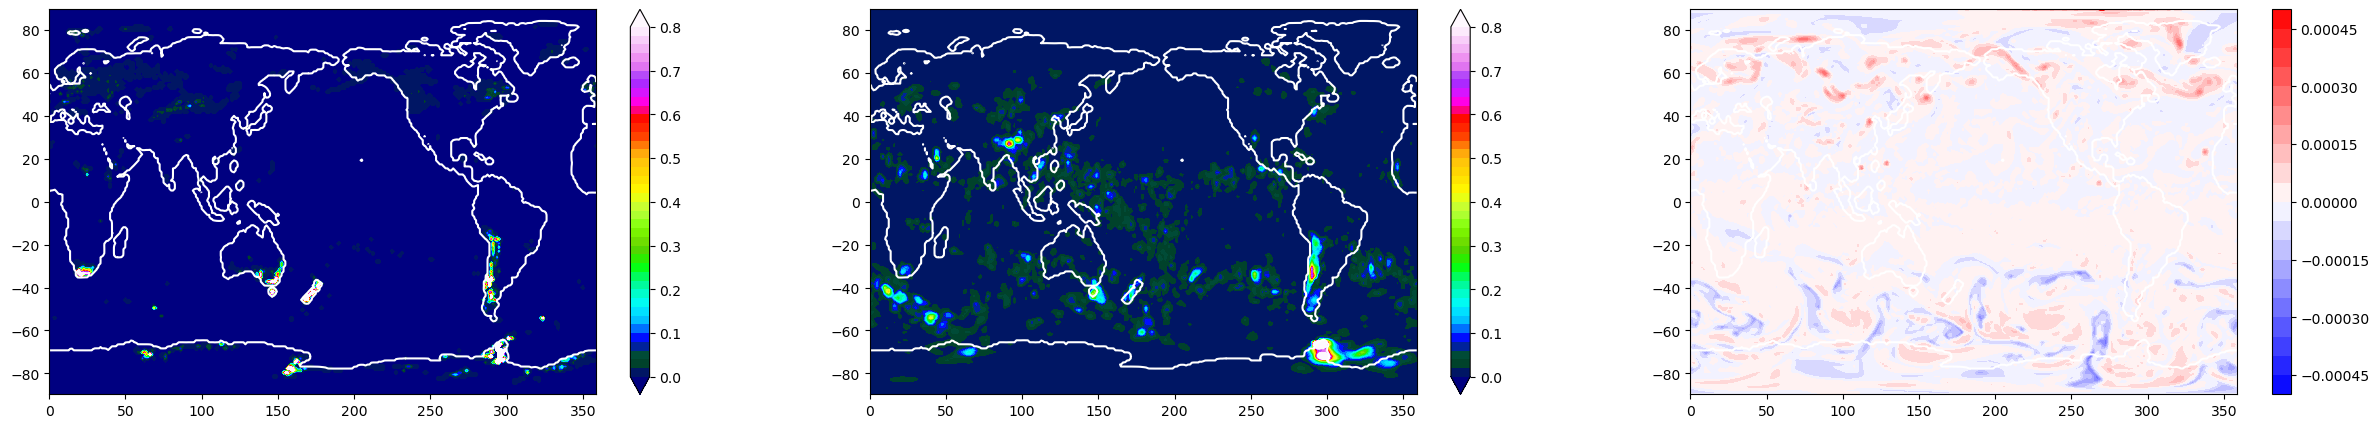

In [46]:
tau_plot=tau  #_movmtn # +tau

mflev=0.1*np.linspace(0,5,num=26)
ztlev=1e-3 * np.linspace( -1,1,num=21)
mflev=8*np.linspace(0,0.1,num=41)

z=11
z=40
zsrc=60
print(zlev[z])

#mflev=0.01*np.linspace(0.,2.5,num=51)
fig,axs=plt.subplots(1,3,figsize=(30,5))
ax=axs[0]
#co=ax.tricontourf( lon,lat, tau_plot.T[z,:], levels=mflev )
co=ax.contourf( lon1,lat1, 9.8*tau_rdg_yxz[:,:,z], levels=mflev , cmap='gist_ncar' , extend='both' )
to=ax.contour( lon1,lat1, htopo_yx, levels=[1,100000],colors='white')
plt.colorbar(co)
ax=axs[1]
co=ax.contourf( lon1,lat1, mpwp_m[0,z,:,:], levels=mflev , cmap='gist_ncar', extend='both'   )
to=ax.contour( lon1,lat1, htopo_yx, levels=[1,100000],colors='white')
plt.colorbar(co)

ax=axs[2]
#co=ax.contourf( lon1,lat1, np.average( np.abs(zeta_yxz[:,:,nz-30:nz-10]), axis=2 ), levels=ztlev, cmap='bwr'  )
co=ax.contourf( lon1,lat1, np.average( zeta_yxz[:,:,65:72], axis=2 ), levels=ztlev/2, cmap='bwr'  )
#co=ax.contourf( lon1,lat1, np.average( np.abs(zeta_yxz[:,:,65:75]), axis=2 ), levels=ztlev/2, cmap='bwr'  )
#co=ax.contourf( lon1,lat1, np.abs(zeta_yxz[:,:,70]), levels=ztlev/2, cmap='bwr'  )
to=ax.contour( lon1,lat1, htopo_yx, levels=[1,100000],colors='white')
plt.colorbar(co)


print( plev[65:72] )
print( lat1[40])

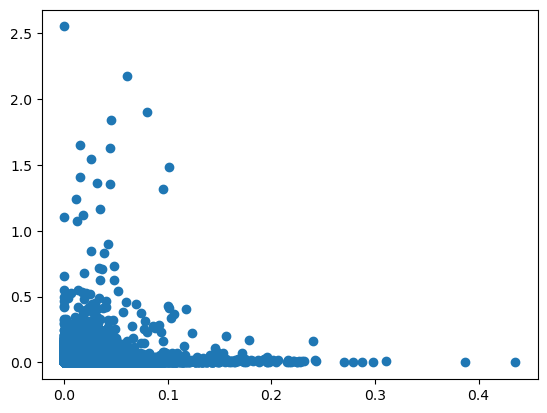

In [38]:
plt.scatter(9.8*tau_movmtn_yxz[:,:,z],mpwp_m[0,z,:,:] )

In [16]:
print( np.shape(zeta_yxz))

lat_plot=-80.
print( np.argmin( np.abs(lat1 - lat_plot) ) )

(192, 288, 93)
11


In [17]:


pv_yxz = np.zeros( (ny,nx,nz) )
dsedz_yxz = np.zeros( (ny,nx,nz) )
duvdz_yxz = np.zeros( (ny,nx,nz) )

for k in np.arange( start=1, stop=nz-1 ):
    dsedz_yxz[:,:,k] = (1./cpair)*(dse_yxz[:,:,k-1] - dse_yxz[:,:,k+1]) / (zma_yxz[:,:,k-1] - zma_yxz[:,:,k+1])
    duvdz_yxz[:,:,k] = np.sqrt( ( (uu_yxz[:,:,k-1] - uu_yxz[:,:,k+1]) / (zma_yxz[:,:,k-1] - zma_yxz[:,:,k+1]) )**2 
                               + 0.*( (vv_yxz[:,:,k-1] - vv_yxz[:,:,k+1]) / (zma_yxz[:,:,k-1] - zma_yxz[:,:,k+1]) )**2 )
                        

pv_yxz = zeta_yxz * dsedz_yxz


46.25
(288, 93)
(93, 288)


Text(0.5, 1.0, 'Pot. vorticity')

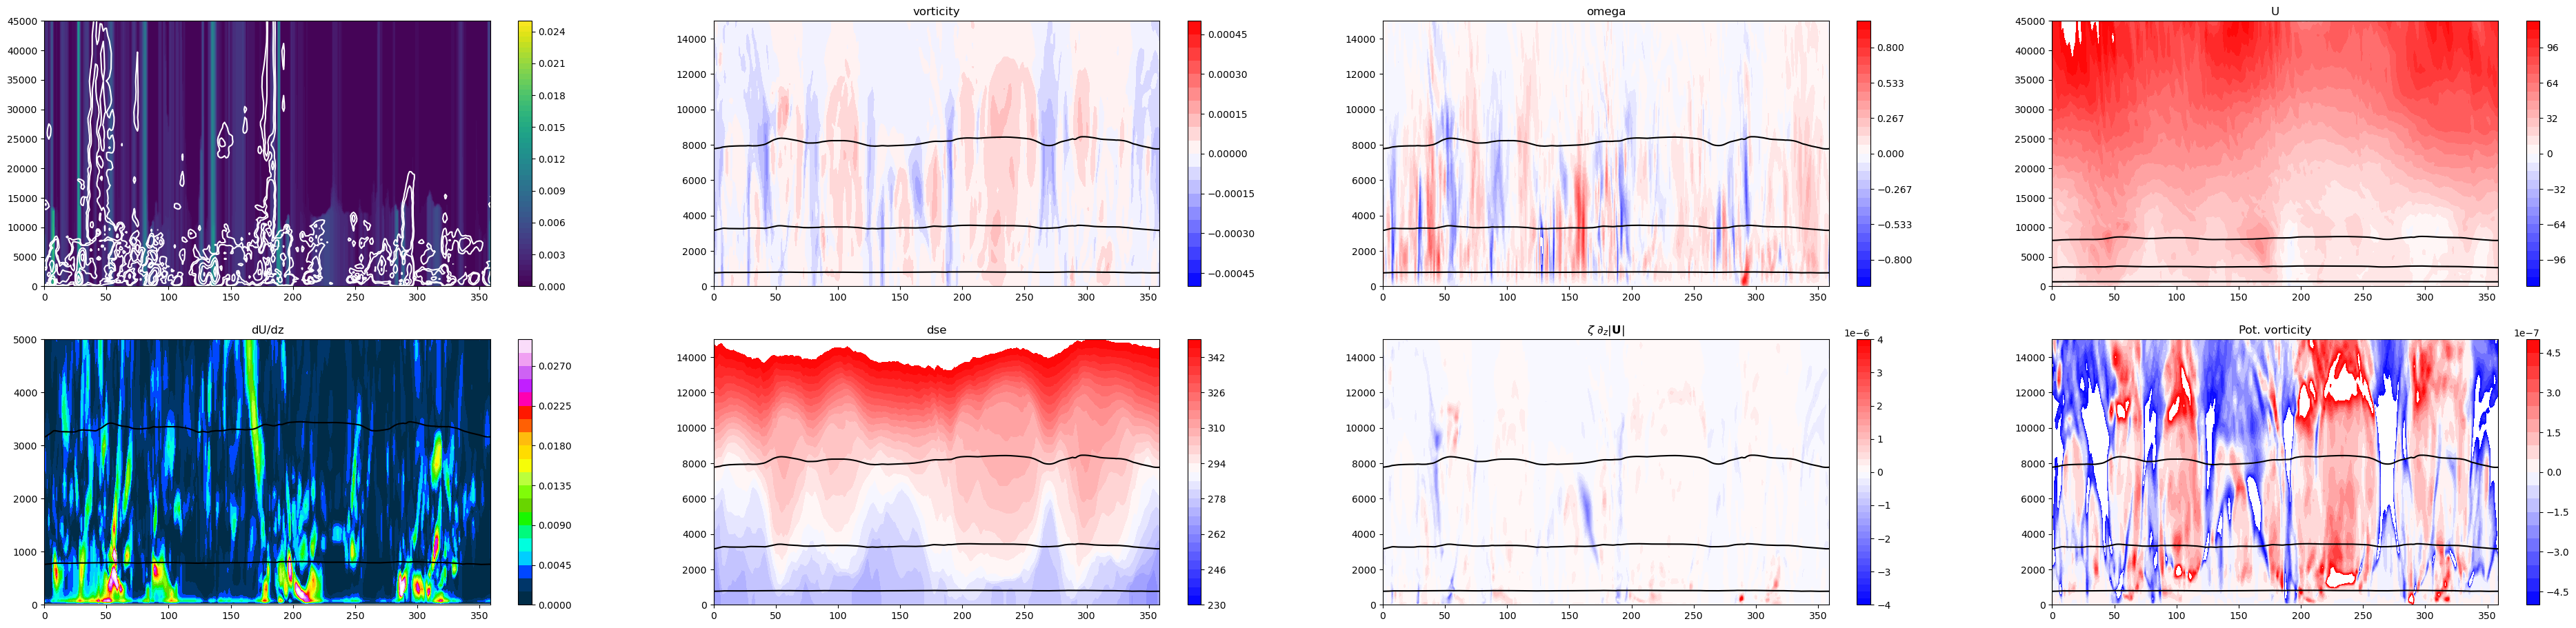

In [18]:

#mflev=0.1*np.linspace(0,5,num=26)
mflev=0.01*np.linspace(0.,2.5,num=51)

shrlev=3e-2 * np.linspace( 0,1,num=21)
ztlev=1e-3 * np.linspace( -1,1,num=21)
pvlev=5e-6 * np.linspace( -1,1,num=21)


lon_plot,lat_plot=40.,-55.
#lon_plot,lat_plot=320.,52.
#lon_plot,lat_plot=175.,-60.

y = np.argmin( np.abs(lat1 - lat_plot) ) 
x = np.argmin( np.abs(lon1 - lon_plot) ) 
print( lon1[y] )

Z2d = zma_yxz[y, :, :].T   # shape (nz, nx)  # levels × longitude
Lon = np.broadcast_to(lon1, Z2d.shape) 


print( Lon.T.shape )
print( Z2d.shape )
fig,axs=plt.subplots(2,4,figsize=(48,11))
axs=axs.flatten()

ax=axs[0]
c=ax.contourf(Lon, Z2d , tau_movmtn_yxz[y,:,1:].T, levels=mflev )
l=ax.contour(Lon, Z2d , 0.1*mpwp_m[0,:,y,:], levels=[0.005,0.01,0.05,.1,.2,.5,1.], colors='white' )

ax.set_ylim(0,45000)
plt.colorbar(c,ax=ax)



ax=axs[1]
#c=ax.contourf( Lon, Z2d ,zeta_m[0,:,y,:], levels=0.1*ztlev, cmap='bwr' )
c=ax.contourf( Lon, Z2d ,zeta_yxz[y,:,:].T, levels=0.5*ztlev, cmap='bwr' )
#c=ax.contourf( Lon, Z2d ,pv_yxz[y,:,:].T, levels=pvlev/10, cmap='bwr' )
ax.plot( lon1, Z2d[83,:] , color='black' )
ax.plot( lon1, Z2d[ksteer,:] , color='black' )
ax.plot( lon1, Z2d[klaunch,:] , color='black' )
ax.set_ylim(0,15000)
plt.colorbar(c,ax=ax)
ax.set_title( f"vorticity" )




ax=axs[2]
#c=ax.contourf( Lon, Z2d ,uu_m[0,:,y,:], levels=np.linspace(-120,120,num=31), cmap='bwr' )
c=ax.contourf( Lon, Z2d ,og_m[0,:,y,:], levels=np.linspace(-1,1,num=31), cmap='bwr' )
ax.set_ylim(0,15000)
ax.plot( lon1, Z2d[83,:] , color='black' )
ax.plot( lon1, Z2d[ksteer,:] , color='black' )
ax.plot( lon1, Z2d[klaunch,:] , color='black' )
plt.colorbar(c,ax=ax)
ax.set_title( f"omega" )

ax=axs[3]
#c=ax.contourf( Lon, Z2d , dse_yxz[y,:,:].T / cpair , levels=np.linspace(270,390,num=31)-40., cmap='bwr' )
c=ax.contourf( Lon, Z2d ,uu_m[0,:,y,:], levels=np.linspace(-120,120,num=31), cmap='bwr' )

ax.set_ylim(0,45000)
ax.plot( lon1, Z2d[83,:] , color='black' )
ax.plot( lon1, Z2d[ksteer,:] , color='black' )
ax.plot( lon1, Z2d[klaunch,:] , color='black' )
plt.colorbar(c,ax=ax)
ax.set_title( f"U" )

ax=axs[4]
#c=ax.contourf( Lon, Z2d , dse_yxz[y,:,:].T / cpair , levels=np.linspace(270,390,num=31)-40., cmap='bwr' )
c=ax.contourf( Lon, Z2d ,duvdz_yxz[y,:,:].T, levels=shrlev, cmap='gist_ncar' )

ax.set_ylim(0,5000)
ax.plot( lon1, Z2d[83,:] , color='black' )
ax.plot( lon1, Z2d[ksteer,:] , color='black' )
ax.plot( lon1, Z2d[klaunch,:] , color='black' )
plt.colorbar(c,ax=ax)
ax.set_title( f"dU/dz" )

ax=axs[5]
c=ax.contourf( Lon, Z2d , dse_yxz[y,:,:].T / cpair , levels=np.linspace(270,390,num=31)-40., cmap='bwr' )


ax.set_ylim(0,15000)
ax.plot( lon1, Z2d[83,:] , color='black' )
ax.plot( lon1, Z2d[ksteer,:] , color='black' )
ax.plot( lon1, Z2d[klaunch,:] , color='black' )
plt.colorbar(c,ax=ax)
ax.set_title( f"dse" )

ax=axs[6]
voshrlev=1.e-6*np.linspace( -4,4,num=41) 
c=ax.contourf( Lon, Z2d , (zeta_yxz*duvdz_yxz)[y,:,:].T  , levels=voshrlev, cmap='bwr' )


ax.set_ylim(0,15000)
ax.plot( lon1, Z2d[83,:] , color='black' )
ax.plot( lon1, Z2d[ksteer,:] , color='black' )
ax.plot( lon1, Z2d[klaunch,:] , color='black' )
plt.colorbar(c,ax=ax)
tt=r"$\zeta~\partial_z |\mathbf{U}| $"

ax.set_title( f"{tt}" )

ax=axs[7]
c=ax.contourf( Lon, Z2d ,pv_yxz[y,:,:].T, levels=pvlev/10, cmap='bwr' )
ax.plot( lon1, Z2d[83,:] , color='black' )
ax.plot( lon1, Z2d[ksteer,:] , color='black' )
ax.plot( lon1, Z2d[klaunch,:] , color='black' )
ax.set_ylim(0,15000)
plt.colorbar(c,ax=ax)
ax.set_title( f"Pot. vorticity" )





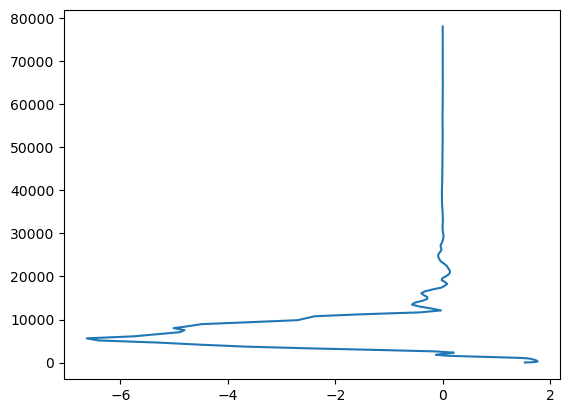

In [19]:
#plt.plot( mpwp_m[0,:,y,x] , Z2d[:,x])

#plt.plot( (pmid_yxz*zeta_yxz)[y,x,:] , pmid_yxz[y,x,:])  #Z2d[:,x])
#plt.plot( (pmid_yxz*zeta_yxz*duvdz_yxz)[y,x,:] , pmid_yxz[y,x,:])  #Z2d[:,x])
#plt.plot( (pmid_yxz*zeta_yxz*duvdz_yxz)[y,x,:] , zm_yxz[y,x,:])  #Z2d[:,x])
plt.plot( (pmid_yxz*zeta_yxz)[y,x,:] , zm_yxz[y,x,:])  #Z2d[:,x])
#plt.plot( (pmid_yxz*pv_yxz)[y,x,:] , pmid_yxz[y,x,:])  #Z2d[:,x])
#plt.ylim(100_000.,0.)



(100000.0, 0.0)

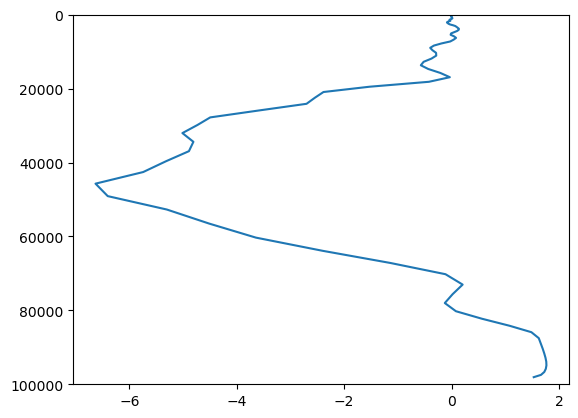

In [20]:
#plt.plot( mpwp_m[0,:,y,x] , Z2d[:,x])

plt.plot( (pmid_yxz*zeta_yxz)[y,x,:] , pmid_yxz[y,x,:])  #Z2d[:,x])
#plt.plot( (pmid_yxz*zeta_yxz*duvdz_yxz)[y,x,:] , pmid_yxz[y,x,:])  #Z2d[:,x])
#plt.plot( (pmid_yxz*zeta_yxz*duvdz_yxz)[y,x,:] , zm_yxz[y,x,:])  #Z2d[:,x])
#plt.plot( (pmid_yxz*pv_yxz)[y,x,:] , pmid_yxz[y,x,:])  #Z2d[:,x])
plt.ylim(100_000.,0.)



In [21]:
int1 = np.sum( (pmid_yxz*np.abs(zeta_yxz))[y,x,:] )/np.sum( np.abs(zeta_yxz)[y,x,:] )

In [22]:
print(int1)

24199.66346321184
